# 한국어 데이터로 챗봇 만들기

# - 목차
1. 데이터 불러오기   
2. 데이터 전처리하기   
3. SubwordTextEncoder 사용하기   
4. 모델 구성하기   
5. 모델 평가하기   

- 프로젝트 정리

## 1. 데이터 불러오기
- 프로젝트에 사용할 한국어 데이터는 [송영숙님 깃허브](https://github.com/songys/Chatbot_data/)에 자세하게 설명되어 있다.
- 인공데이터이며 일부 이별과 관련된 질문에서 [다음카페 사랑보다 아름다운 실연]( http://cafe116.daum.net/_c21_/home?grpid=1bld)에서 자주 나오는 이야기들을 참고하여 제작했다고 한다.
- 챗봇 트레이닝용 문답 페어는 11,876개로 Q가 질문, A가 답변이며 일상다반서 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링 되어 있다.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv(os.getenv('HOME') + '/aiffel/songys_chatbot/ChatbotData.csv')

print(data.shape)

data.head()

(11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [9]:
#결측치 확인
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

## 2. 데이터 전처리하기

In [10]:
#전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    #단어와 구두점(punctuation) 사이의 거리를 만듦.
    #단어와 온점 사이에 거리를 만듦.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    #(a-z, A-Z, 한글, 숫자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체.
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

In [17]:
#질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []

    for i in range(len(data) - 1):
        #전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(data['Q'].values[i]))
        outputs.append(preprocess_sentence(data['A'].values[i]))
        
        #전체 데이터 전부 사용하므로 샘플 최대 개수를 정하지 않음.
        #if len(inputs) >= MAX_SAMPLES:
        #    return inputs, outputs

    return inputs, outputs

In [18]:
#데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11822
전체 샘플 수 : 11822


In [31]:
#전처리 잘 되었는지 확인

import random

#랜덤으로 인덱스 뽑아서 5개만 확인할 것.
length = list(range(0,11822,1))
random.shuffle(length)

for i in (length[:5]) :
    print('전처리 후의 {}번째 질문 샘플: {}'.format(i+1, questions[i]))
    print('전처리 후의 {}번째 답변 샘플: {}'.format(i+1, answers[i]))

전처리 후의 5868번째 질문 샘플: 내가 그리운만큼 그대도 그리운가
전처리 후의 5868번째 답변 샘플: 궁금해하지마세요 .
전처리 후의 8401번째 질문 샘플: 하늘이 준 이별 같다
전처리 후의 8401번째 답변 샘플: 운명같네요 .
전처리 후의 6219번째 질문 샘플: 마지막 문자를 보내버렸어
전처리 후의 6219번째 답변 샘플: 미련이 남았나봐요 .
전처리 후의 3893번째 질문 샘플: 자기 소개 어떻게 해
전처리 후의 3893번째 답변 샘플: 강렬하고 자신감있게 하면 되지 않을까싶어요 .
전처리 후의 8326번째 질문 샘플: 최근에 헤어졌어
전처리 후의 8326번째 답변 샘플: 큰 일을 겪었네요 .


## 3. SubwordTextEncoder 사용하기

### 3.1 병렬 데이터 처리 
- TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.
- 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩한다.
- 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
- 최대 길이 MAX_LENGTH를 넘는 문장들은 필터링한다.
- 최대 길이 MAX_LENGTH보다 길이가 짧은 문장은 이에 맞도록 패딩 한다.

In [33]:
print(tf.__version__)

2.4.1


In [34]:
#질문과 답변 데이터셋에 대해서 Vocabulary 생성.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [35]:
#디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여함.
#이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여.

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8161]
END_TOKEN의 번호 : [8162]


In [36]:
#시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8163


In [38]:
#각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
#okenizer.encode()로 각 단어를 정수로 변환
#또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환

#임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
#각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5756, 610, 2486, 4158]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7501, 7, 6265, 98, 1]


In [39]:
#질문과 답변의 길이 확인
question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(question_len)))
print('질문의 최대 길이 : {}'.format(np.max(question_len)))
print('질문의 평균 길이 : {}'.format(np.mean(question_len)))
print('답변의 최소 길이 : {}'.format(np.min(answer_len)))
print('답변의 최대 길이 : {}'.format(np.max(answer_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answer_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.937996954829978
답변의 최소 길이 : 1
답변의 최대 길이 : 24
답변의 평균 길이 : 4.716037895449163


- 질문의 최대 길이가 16이므로 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이를 16으로 정함.

In [40]:
#샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 16
print(MAX_LENGTH)

16


In [41]:
#정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        #정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        #최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    #최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [42]:
#샘플 길이가 16 넘는 경우는 샘플 필터링을 하여 일부 샘플이 제거 되었음.
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8163
필터링 후의 질문 샘플 개수: 11675
필터링 후의 답변 샘플 개수: 11675


### 3.2 교사 강요(Teacher Forcing) 사용
- tf.data.Dataset API는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API임.
- 이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 함.
- 이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 교사 강요(Teacher Forcing) 이라는 언어 모델의 훈련 기법을 이해해야만 함.
- 교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미침.

In [43]:
#질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성.
#교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용.

BATCH_SIZE = 64
BUFFER_SIZE = 20000

#디코더는 이전의 target을 다음의 input으로 사용.
#이에 따라 outputs에서는 START_TOKEN을 제거.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 4. 모델 구성하기

### 4.1  함수 정의

### - PositionalEncoding Layer

In [45]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        #배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        #배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### - Attention

In [46]:
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산"""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    #add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    #softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [47]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads
    
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        #linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        #병렬 연산을 위한 머리를 여러 개 만듦.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        #스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        #어텐션 연산 후에 각 결과를 다시 연결(concatenate).
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        #final linear layer
        outputs = self.dense(concat_attention)

        return outputs

### - MASK

In [48]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    #(batch_size, 1, 1, sequence length)
    
    return mask[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)

    return tf.maximum(look_ahead_mask, padding_mask)

### - Encoder
- 하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)인 셀프 어텐션과 피드 포워드 신경망으로 나누어짐.
- 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어짐.
- 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성함.
- 인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용함.
- 트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓음.
- 학습 시간을 고려해 2개의 인코더 층만 쌓음.

In [49]:
#두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수
#함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있음.
#이 하나의 레이어 안에는 두 개의 서브 레이어가 존재.

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    #패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    #첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    #어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    #두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    #완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [50]:
#트랜스포머 인코더

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    #패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    #임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    #포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    #num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i), )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### - Decoder
- 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있음.
- 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정.
- 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행함.
- 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성.
- num_layers 개수의 디코더 층을 쌓음.
- 학습 시간을 고려해서 2개의 디코더 레이어를 쌓음

In [51]:
#디코더 세 개의 서브 층 내부적으로 구현한 함수
#디코더 하나의 레이어를 함수로 구현.
#이 하나의 레이어 안에는 세 개의 서브 레이어가 존재.

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    #첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    #멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    #두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    #마스크드 멀티 헤드 어텐션의 결과는
    #Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    #세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    #완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],outputs=outputs,name=name)

In [52]:
#트랜스포머 디코더

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    #패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    #임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    #포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    #Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i), )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],outputs=outputs,name=name)

### - Transformer

In [53]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    #인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),name='enc_padding_mask')(inputs)

    #디코더에서 미래의 토큰을 마스크 하기 위해서 사용.
    #내부적으로 패딩 마스크도 포함되어져 있음.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,output_shape=(1, None, None),name='look_ahead_mask')(dec_inputs)

    #두 번째 어텐션 블록에서 인코더의 벡터들 마스킹
    #디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),name='dec_padding_mask')(inputs)

    #인코더
    enc_outputs = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout, )(inputs=[inputs, enc_padding_mask])

    #디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout, )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    #완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 4.2 모델 생성

In [54]:
#num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값
#num_layers와 d-Model의 값은 시간 상 작은 값들 사용.

tf.keras.backend.clear_session()

#하이퍼파라미터
NUM_LAYERS = 2    #인코더와 디코더의 층의 개수
D_MODEL = 256    #인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8    #멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512    #피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1    #드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3143936     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### - 손실 함수

In [55]:
#레이블인 시퀀스에 패딩이 되어 있으므로 loss 계산 시 패딩 마스크 적용해야 함.
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### - 커스텀 학습률(Learning rate) 스케줄링

In [56]:
#최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 
#이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있음.
#이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라 함.

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

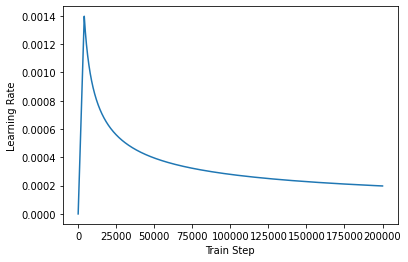

In [57]:
#커스텀 학습률 스케줄링 계획 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

- 학습 초기에는 learning_rate가 step_numstep_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있음.

### 4.3 모델 컴파일

In [58]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 4.4 모델 훈련

In [59]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
183/183 [==============================] - 18s 61ms/step - loss: 3.8929 - accuracy: 0.0363
Epoch 2/20
183/183 [==============================] - 11s 60ms/step - loss: 3.1640 - accuracy: 0.1279
Epoch 3/20
183/183 [==============================] - 11s 60ms/step - loss: 2.6226 - accuracy: 0.1302
Epoch 4/20
183/183 [==============================] - 11s 60ms/step - loss: 2.4018 - accuracy: 0.1377
Epoch 5/20
183/183 [==============================] - 11s 60ms/step - loss: 2.2444 - accuracy: 0.1468
Epoch 6/20
183/183 [==============================] - 11s 60ms/step - loss: 2.0901 - accuracy: 0.1577
Epoch 7/20
183/183 [==============================] - 11s 60ms/step - loss: 1.9197 - accuracy: 0.1713
Epoch 8/20
183/183 [==============================] - 11s 60ms/step - loss: 1.7369 - accuracy: 0.1923
Epoch 9/20
183/183 [==============================] - 11s 60ms/step - loss: 1.5269 - accuracy: 0.2173
Epoch 10/20
183/183 [==============================] - 11s 60ms/step - loss: 1.309

## 5. 모델 평가하기 - 챗봇 테스트하기
- 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
- 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
- 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
- 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
- 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
- END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [60]:
#위의 6가지 과정을 모두 담은 함수 생성
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    #입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    #디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    #처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장.
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    #디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        
        #디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        #현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        #만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        #예측한 단어들은 지속적으로 output_sequence에 추가.
        #이 output_sequence는 다시 디코더의 입력.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [61]:
#임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 함수

def sentence_generation(sentence):
    
    #입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴.
    prediction = decoder_inference(sentence)

    #정수 시퀀스를 다시 텍스트 시퀀스로 변환.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [62]:
#입력문장에 대한 답변 확인
sentence_generation('안녕')

입력 : 안녕
출력 : 안녕하세요 .


'안녕하세요 .'

In [63]:
sentence_generation('뭐해?')

입력 : 뭐해?
출력 : 실내 데이트요 .


'실내 데이트요 .'

In [64]:
sentence_generation('밥은?')

입력 : 밥은?
출력 : 정신이 힘든 건지 몸이 아픈 건지 확인해 보세요 .


'정신이 힘든 건지 몸이 아픈 건지 확인해 보세요 .'

In [67]:
sentence_generation('밥 먹었어?')

입력 : 밥 먹었어?
출력 : 저는 배터리가 밥이예요 .


'저는 배터리가 밥이예요 .'

In [65]:
sentence_generation('무슨 일 있어?')

입력 : 무슨 일 있어?
출력 : 해주고 티를 팍팍 내세요 .


'해주고 티를 팍팍 내세요 .'

In [66]:
sentence_generation('오늘 기분 어때?')

입력 : 오늘 기분 어때?
출력 : 저랑 놀아요 .


'저랑 놀아요 .'

In [68]:
sentence_generation('이름이 뭐야?')

입력 : 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

In [69]:
sentence_generation('오늘 좀 우울해.')

입력 : 오늘 좀 우울해.
출력 : 제 앞에서 울어도 돼요 .


'제 앞에서 울어도 돼요 .'

In [70]:
sentence_generation('오늘 기분 좋은 일 있었어.')

입력 : 오늘 기분 좋은 일 있었어.
출력 : 저도 좋아요 .


'저도 좋아요 .'

In [71]:
sentence_generation('여행 가고 싶다.')

입력 : 여행 가고 싶다.
출력 : 저도 같이 가요 .


'저도 같이 가요 .'

---

# - 프로젝트 정리   

1. 코드 내용 수정   
- 전처리 과정에서 한글도 포함하도록 수정했다.    
: "[^a-zA-Z?.!,]+"   ➡   "[^가-힣a-zA-Z0-9?.!,]+"  
   
- 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수에서 실습 노드 그대로 사용했더니 자꾸 오류가 나서 간략하게 수정하여 사용했다.   


2. 하이퍼 파라미터 조정   

- 배치 사이즈나 하이퍼 파라미터를 조금씩 변경 해 봤으나 모델 학습 결과는 큰 차이가 없었다.   


3. 챗봇 테스트   
- 트랜스포머 모델이 수렴하는 결과를 보였다.   

- 모델 평가(챗봇 테스트)를 총 10번 진행했는데 7번이나 제대로 된 대답을 했다.   

- 물론 "밥은?"과 "밥 먹었어?"는 동일한 의미이지만 전자는 제대로 된 답을 하지 못했고 후자는 제대로 된 답을 했다.    

- 완전한 문장이 아니라 제대로 인식을 못하고 엉뚱한 대답을 내 놓은 것 같다.   

- 완전한 문장이 아니어도 같은 의미를 가지는 경우에도 제대로 된 대답을 할 수 있으려면 모델의 성능을 개선 시도가 필요할 것 같다.   